## PAROXYSMAL ATRIAL FIBRILLATION CLASSIFICATION BY MLP

Paroxysmal atrial fibrillation (PAF), as being a type of arrhythmia of the heart that occurs spontaneously, has been the interest of researchers for more than a decade. Due to its spontaneous nature, it is hard to get ECG readings during PAF attacks. Therefore, classification methods have been developed to diagnose PAF patients, from the electrocardiogram (ECG) records with normal sinus rhythm. The purpose of this study is to utilize recent developments in deep neural network to find a better classifier to achieve higher accuracies. MLP is used to achieve classification goal of labelling the PAF subject as 1 and 0 otherwise. 

If this is achieved, considering that we have data collection possibilities via mobile phones, the second step is going to be early warning to prevent many issues that may arise with a sudden PAF attack (such as while driving..)

The dataset is from Physionet "The research resource for complex physiologic signals". Retrieved from physionet.org: https://www.physionet.org and used in “The PAF Prediction Challenge” in 2001.

This database is described in
Moody GB, Goldberger AL, McClennen S, Swiryn SP. Predicting the Onset of Paroxysmal Atrial Fibrillation: The Computers in Cardiology Challenge 2001. Computers in Cardiology28:113-116 (2001).
Citation for PhysioNet:
Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/content/101/23/e215.full]; 2000 (June 13).

In this study, I utilized the outcome of a phd thesis. (Hilavin, I. (2016). Development of a System to Diagnose Atrial Fibrillation Patients From Arrythmia Free ECG Records. İzmir, Turkey: DEU.) In her study, Ms. Hilavin created 33 features (like Mean RR, Std RR etc) from PAF dataset and through Genetic Algorithms, she has found out the most describing 8 features. By taking these 8 features and implementing SVM classifier she achieved over 90% accuracy.

When we want to use the dataset for a DL algorithm, the first thing to realize is that the data is not big enough for the model to be trained. (50 person with PAF and 50  person without) 

Hilavin’s preprocessed data is considered to be doing some part of the DL network’s job and MLP is decided to be used with that derived dataset which has 798 rows and 8 features.

### Result
The results do not seem to be satisfactory.It needs to be further analyzed.

### Thanks to Udacity and Facebook for Pytorch Challenge

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torchvision import transforms
from torch import nn, optim
import torch.utils.data as data_utils
from torch.optim import lr_scheduler
from torch.autograd import Variable
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

Reading the data

In [2]:
data = pd.read_csv('paf8.csv')
data.head(3)

,Mean RR,Std RR,HF peak,LF power prc,HF power prc,SD1,SampEn,DFA ɑ1,PAF1,Kişi numarası
0,0.7109,0.1273,0.4438,0.0753,0.9335,0.1330,0.8583,0.2020,1,1
1,0.7052,0.1032,0.4064,0.0492,0.9257,0.1251,0.6426,0.1596,1,1
2,0.7022,0.1240,0.3823,0.1474,0.8228,0.1174,0.7113,0.2397,1,1


Checking if there is missing data

In [3]:
data.isnull().sum() 

Mean RR          0
Std RR           0
HF peak          0
LF power prc     0
HF power prc     0
SD1              0
SampEn           0
DFA ɑ1           0
PAF1             0
Kişi numarası    0
dtype: int64

In order to see the distribution of features values

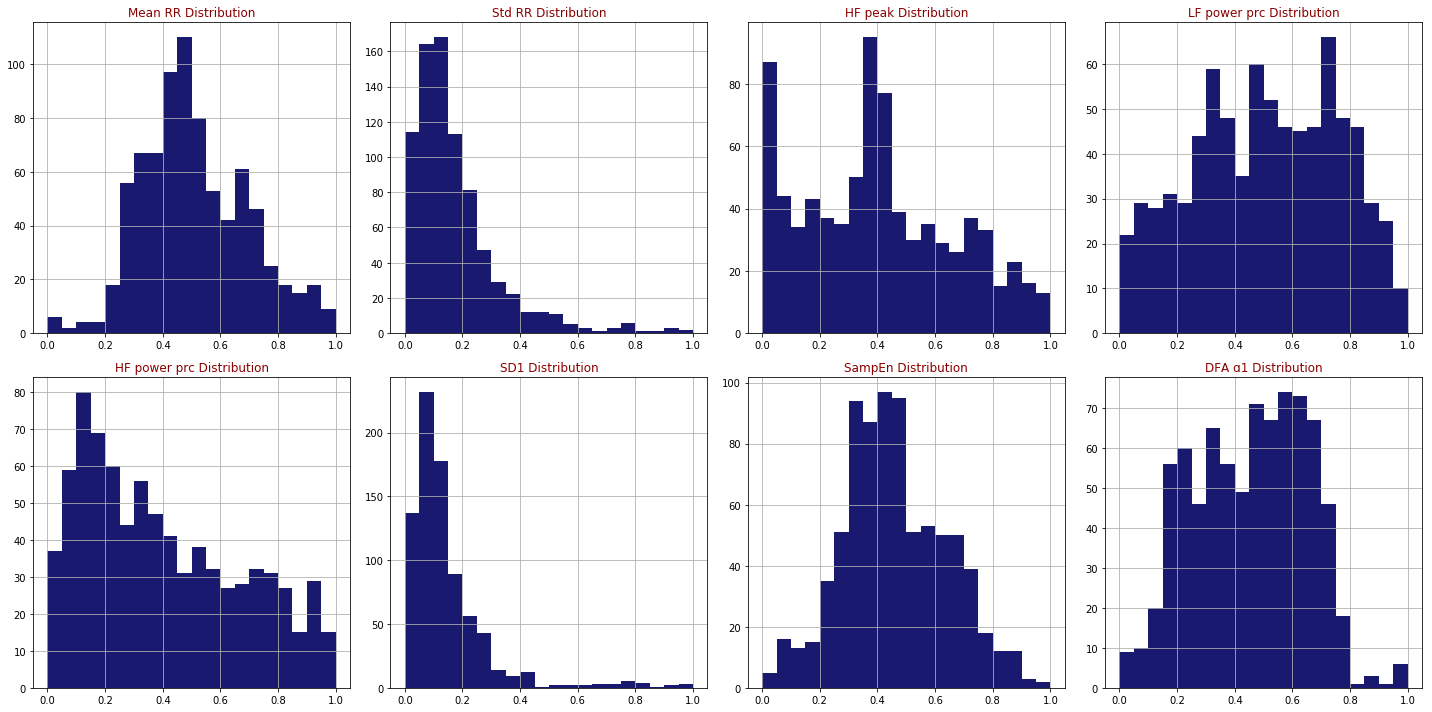

In [4]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,10))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax, facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(data,data.columns[0:8],2,4)

To see the distribution of PAF subjects on these features

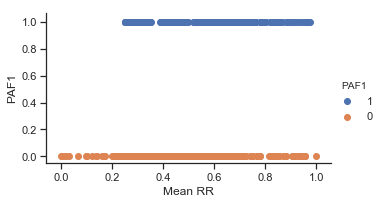

In [5]:
seaborn.set(style='ticks')
fg = seaborn.FacetGrid(data=data, hue=data.columns[8], hue_order=[1,0], aspect=1.61)
fg.map(plt.scatter, 'Mean RR', 'PAF1').add_legend()

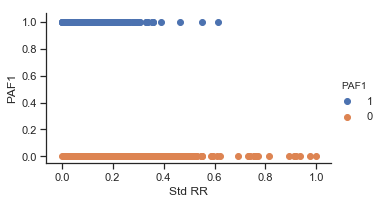

In [6]:
fg = seaborn.FacetGrid(data=data, hue=data.columns[8], hue_order=[1,0], aspect=1.61)
fg.map(plt.scatter, 'Std RR', 'PAF1').add_legend()

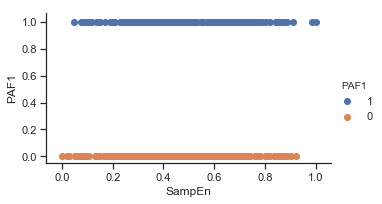

In [7]:
fg = seaborn.FacetGrid(data=data, hue=data.columns[8], hue_order=[1,0], aspect=1.61)
fg.map(plt.scatter, 'SampEn', 'PAF1').add_legend()

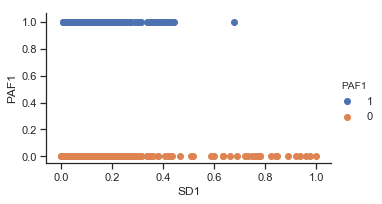

In [8]:
fg = seaborn.FacetGrid(data=data, hue=data.columns[8], hue_order=[1,0], aspect=1.61)
fg.map(plt.scatter, 'SD1', 'PAF1').add_legend()

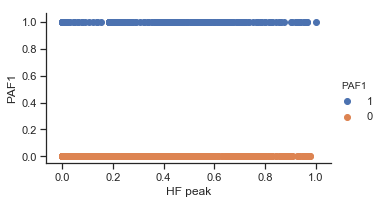

In [9]:
fg = seaborn.FacetGrid(data=data, hue=data.columns[8], hue_order=[1,0], aspect=1.61)
fg.map(plt.scatter, 'HF peak', 'PAF1').add_legend()

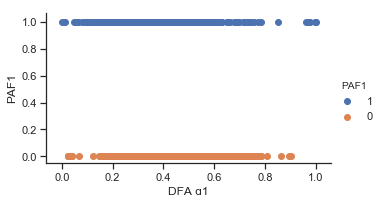

In [10]:
fg = seaborn.FacetGrid(data=data, hue=data.columns[8], hue_order=[1,0], aspect=1.61)
fg.map(plt.scatter, 'DFA ɑ1', 'PAF1').add_legend()

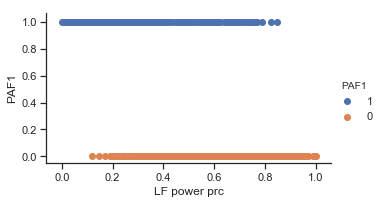

In [11]:
fg = seaborn.FacetGrid(data=data, hue=data.columns[8], hue_order=[1,0], aspect=1.61)
fg.map(plt.scatter, 'LF power prc', 'PAF1').add_legend()

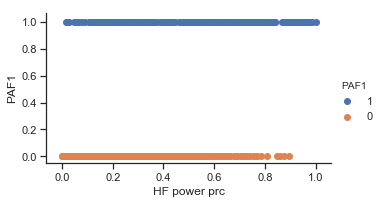

In [12]:
fg = seaborn.FacetGrid(data=data, hue=data.columns[8], hue_order=[1,0], aspect=1.61)
fg.map(plt.scatter, 'HF power prc', 'PAF1').add_legend()

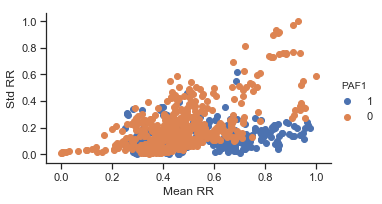

In [13]:
gir = {1:"Mean RR", 2:"Std RR", 3:"SampEn", 4:"SD1", 5:"HF peak", 6:"DFA ɑ1", 7:"LF power prc", 8:"HF power prc"}
def zx(arg1, arg2):
    fg = seaborn.FacetGrid(data=data, hue=data.columns[8], hue_order=[1,0], aspect=1.61)
    fg.map(plt.scatter, arg1, arg2).add_legend()
zx(gir[1], gir[2])
    

Print data shape and column info

In [14]:
print("data shape = ", data.shape, "\ndata column names = ", data.columns)

data shape =  (798, 10) 
data column names =  Index(['Mean RR', 'Std RR', 'HF peak', 'LF power prc', 'HF power prc', 'SD1',
       'SampEn', 'DFA ɑ1', 'PAF1', 'Kişi numarası'],
      dtype='object')


Shuffle data by rows to have different input order to system

In [15]:
data = shuffle(data)
data.head()

,Mean RR,Std RR,HF peak,LF power prc,HF power prc,SD1,SampEn,DFA ɑ1,PAF1,Kişi numarası
701,0.4492,0.0526,0.8656,0.6511,0.1727,0.0757,0.3351,0.5120,0,85
719,0.9403,0.3875,0.0411,0.7899,0.1661,0.2969,0.4723,0.5631,0,87
498,0.4682,0.3417,0.5530,0.6536,0.3058,0.2630,0.5969,0.5309,0,68
628,0.7232,0.5070,0.0307,0.6512,0.2553,0.3380,0.3928,0.5505,0,79
366,0.2162,0.0475,0.3533,0.4647,0.5081,0.0705,0.3632,0.1812,0,56


Convert to torch Float Tensor

In [16]:
data = torch.FloatTensor(data.values)

Print sample data from new set

In [17]:
print("data[0,1] = ",data[0,1], "\ndata.shape =", data.shape)

data[0,1] =  tensor(0.0526) 
data.shape = torch.Size([798, 10])


In [18]:
len(data)

798

Function for columnwise normalizing the data

In [19]:
def normalize(t):
    t = t/t.max(dim=0)[0]
    t = (t-t.mean(dim=0))/t.std(dim=0)
    return t
t = torch.tensor([[1000, 3, 0.15], [500, 4, 0.35], [300, 8, 0.55]])
print(normalize(t))

tensor([[ 1.1094, -0.7559, -1.0000],
        [-0.2774, -0.3780,  0.0000],
        [-0.8321,  1.1339,  1.0000]])


Seperating data as input and output 8 column input and 1 column output (ignore 10th column)
Normalize only the input columns. Output is binary 0-1 categories. Combine input and output together

In [20]:
data_in = data[:, 0:8]
data_out = data[:, 8:9]

In [21]:
data_in = normalize(data_in)
data_in = data_in.float()
data = torch.cat((data_in, data_out), 1)

Sample data for view

In [22]:
x = data[:, 0:8]
x[0:3, :]

tensor([[-0.3318, -0.8011,  1.7725,  0.5737, -0.8407, -0.4818, -0.6856,  0.2954],
        [ 2.3403,  1.3919, -1.3936,  1.1311, -0.8651,  1.0296,  0.0749,  0.5579],
        [-0.2284,  1.0920,  0.5721,  0.5838, -0.3479,  0.7980,  0.7657,  0.3925]])

In [23]:
y = data[:, 8:9]
y[0:3, :]

tensor([[0.],
        [0.],
        [0.]])

Splitting the data for train (80%), validation (10%), test (10%)

In [24]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(data)*split_frac)
train_x, remaining_x = x[:split_idx], x[split_idx:]
train_y, remaining_y = y[:split_idx], y[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.size()), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape),
      "\nTrain label: \t\t{}".format(train_y.shape), 
      "\nValidation label: \t{}".format(val_y.shape),
      "\nTest label: \t\t{}".format(test_y.shape))

			Feature Shapes:
Train set: 		torch.Size([638, 8]) 
Validation set: 	torch.Size([80, 8]) 
Test set: 		torch.Size([80, 8]) 
Train label: 		torch.Size([638, 1]) 
Validation label: 	torch.Size([80, 1]) 
Test label: 		torch.Size([80, 1])


Preparing the train validation test dataloaders

In [25]:
train = data_utils.TensorDataset(train_x, train_y)
train_loader = data_utils.DataLoader(train, batch_size=8, shuffle=True)
validation = data_utils.TensorDataset(val_x, val_y)
validation_loader = data_utils.DataLoader(validation, batch_size=8, shuffle=True)
test = data_utils.TensorDataset(test_x, test_y)
test_loader = data_utils.DataLoader(test, batch_size=80, shuffle=True)

Network architecture

In [26]:
model = nn.Sequential(nn.Linear(8, 64),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(64, 64),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(64, 1),
                      nn.Sigmoid())

# Define the loss
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.5)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3)
  (6): Linear(in_features=64, out_features=1, bias=True)
  (7): Sigmoid()
)


Training and validation

In [27]:
epochs = 1000

train_losses, val_losses = [], []
for e in range(epochs):
    running_loss = 0
    accuracyT = 0
    for inputs, labels in train_loader:
       
        optimizer.zero_grad()
        
        log_ps = model(inputs)
        
        
        loss = criterion(log_ps, labels)
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        equals = log_ps == labels.view(*log_ps.shape)              
        accuracyT += torch.mean(equals.type(torch.FloatTensor))
    else:
        
        val_loss = 0
        accuracy = 0
        model.eval()
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for inputs, labels in validation_loader:

                log_ps = model(inputs)
                
                loss = criterion(log_ps, labels)                
                val_loss += loss.item()
                
                equals = log_ps == labels.view(*log_ps.shape)              
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        #scheduler.step()        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(validation_loader))
        if e % 10 == 9:
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                  "Validation Loss: {:.3f}.. ".format(val_loss/len(validation_loader)),
                  "Training Acc.: {:.3f}".format(accuracyT/len(train_loader)),
                  "Validation Acc.: {:.3f}".format(accuracy/len(validation_loader)))
        model.train()

Epoch: 10/1000..  Training Loss: 0.265..  Validation Loss: 0.245..  Training Acc.: 0.006 Validation Acc.: 0.000
Epoch: 20/1000..  Training Loss: 0.229..  Validation Loss: 0.230..  Training Acc.: 0.047 Validation Acc.: 0.000
Epoch: 30/1000..  Training Loss: 0.206..  Validation Loss: 0.230..  Training Acc.: 0.058 Validation Acc.: 0.050
Epoch: 40/1000..  Training Loss: 0.198..  Validation Loss: 0.252..  Training Acc.: 0.089 Validation Acc.: 0.125
Epoch: 50/1000..  Training Loss: 0.195..  Validation Loss: 0.236..  Training Acc.: 0.125 Validation Acc.: 0.138
Epoch: 60/1000..  Training Loss: 0.161..  Validation Loss: 0.220..  Training Acc.: 0.128 Validation Acc.: 0.175
Epoch: 70/1000..  Training Loss: 0.147..  Validation Loss: 0.373..  Training Acc.: 0.158 Validation Acc.: 0.175
Epoch: 80/1000..  Training Loss: 0.143..  Validation Loss: 0.266..  Training Acc.: 0.161 Validation Acc.: 0.213
Epoch: 90/1000..  Training Loss: 0.139..  Validation Loss: 0.293..  Training Acc.: 0.160 Validation Acc.

Epoch: 740/1000..  Training Loss: 0.090..  Validation Loss: 0.784..  Training Acc.: 0.430 Validation Acc.: 0.412
Epoch: 750/1000..  Training Loss: 0.088..  Validation Loss: 0.733..  Training Acc.: 0.434 Validation Acc.: 0.438
Epoch: 760/1000..  Training Loss: 0.058..  Validation Loss: 0.705..  Training Acc.: 0.398 Validation Acc.: 0.387
Epoch: 770/1000..  Training Loss: 0.065..  Validation Loss: 0.616..  Training Acc.: 0.412 Validation Acc.: 0.400
Epoch: 780/1000..  Training Loss: 0.117..  Validation Loss: 0.888..  Training Acc.: 0.455 Validation Acc.: 0.425
Epoch: 790/1000..  Training Loss: 0.098..  Validation Loss: 0.538..  Training Acc.: 0.436 Validation Acc.: 0.463
Epoch: 800/1000..  Training Loss: 0.061..  Validation Loss: 1.074..  Training Acc.: 0.406 Validation Acc.: 0.400
Epoch: 810/1000..  Training Loss: 0.132..  Validation Loss: 1.652..  Training Acc.: 0.473 Validation Acc.: 0.412
Epoch: 820/1000..  Training Loss: 0.143..  Validation Loss: 1.053..  Training Acc.: 0.435 Valida

Testing the result

In [28]:
test_loss = 0
step = 0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        log_ps = model(inputs)
        
                
        loss = criterion(log_ps, labels)                
        test_loss += loss.item()
                
        equals = log_ps == labels.view(*log_ps.shape)              
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    print("Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Test Loss: 1.223..  Test Accuracy: 0.325
